# Notebook for testing the SETP-identification algorithms

In [15]:
from classes import *
#in classes, also tipping will be imported!

import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import random
import ruptures as rpt

from tqdm.notebook import trange, tqdm
from pathlib import Path

from matplotlib import patches
from matplotlib.collections import PatchCollection

In [16]:
#Load the experiments
input_path = "temp/experiments/experiment_selection_2021_2_19.p"
assert Path(input_path).exists()
experiments = pickle.load( open( input_path, "rb" ) )
print(len(experiments))

1400


The overlap in this list can be easily explained; each unique experiment has 4 Metrics!!!

In [17]:
#SET THE PARAMETERS TO DO THE ANALYSIS
window = 4 #The size of the rolling window
margin = 3 # The margin around the TP

#Criteria
c1 = 0.15 #fraction of change relative to house price at t0
c2 = 1e9 #variance
c3 = 10 #percent

In [18]:
#experiments = experiments[0:100]

with tqdm(total=len(experiments)) as pbar:
    for experiment in experiments:
        experiment.create_Metrics() #TODO: GIVE CONTROL OVER THE METRICS TO BE CREATED
        for M in experiment.allMetrics:
            M.create_statistics(window=window) #Create summary statistics for the metric(t)
            M.find_SETP_candidates(c1=c1,c2=c2,c3=c3,margin=margin)
            M.select_SETPs(sign=-1,add_stable_before=True) #Also consider states which are only stable before as policy relevant
        pbar.update(1)
            #M.plot_both(figsize=(15,20),exp_name=experiment.name)

### Visualisations of individual experiments

In [19]:
#todo: move to tipping.py

def add_suptitle(fig,exp,M):
    """Add some information about the experiment as title to the figure
    
    Arguments:
        fig (Matplotlib Figure) : Figure created with M.plot_SETPs
        exp : experiment object from which to draw the metadata
        metric : the metric from which to draw the metadata
        
    Returns:
        fig (Matplotlib Figure) : the input figure with a suptitle
    
    """
    
    #Make the data of the experiment more readable before sending it to the string
    housing_market = M.name.split('_')[-1]
    if housing_market == 'subj':  housing_market = 'Boundedly rational'
    else: housing_market = 'Rational'
    
    area_name = M.name.split('_')[1]
    if area_name == 'A': area_name = 'A (Heijplaat, outer-dike)'
    else: area_name = 'B (City Centre, inner-dike)'
    
    #Create the title string
    suptitle_string = (\
    '''Sea level rise scenario: {} ||| Storm surge series: {} ||| Mayor: {}
    {} housing market ||| Area {}'''.format(
                                   exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1],
                                   exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1],        
                                   exp.Mayor.get_name(),
                                   housing_market,
                                   area_name))
    fig.suptitle(suptitle_string)
    
    file_string = exp.SurgeLevel.corresponding_SLR_Scenario.name.split('_')[-1] + '_' +\
                  exp.SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1] + '_' + \
                  exp.Mayor.get_name() + '_' + M.name.split('_')[-1] + '_' + M.name.split('_')[1]
    return fig,file_string
    

In [20]:
#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations',date,'21_TP_identification')
if not target.exists(): target.mkdir(parents=True)
else: print("Target folder {} already exists".format(target))

Target folder Visualisations\2021_2_19\21_TP_identification already exists


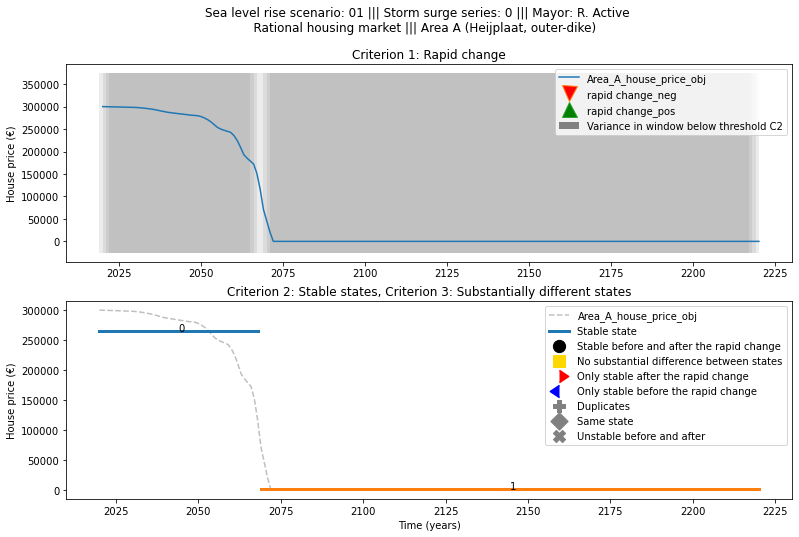

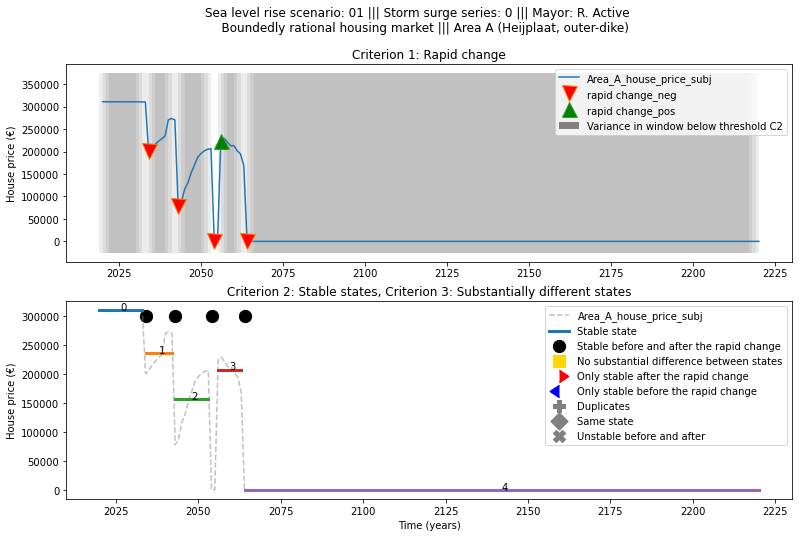

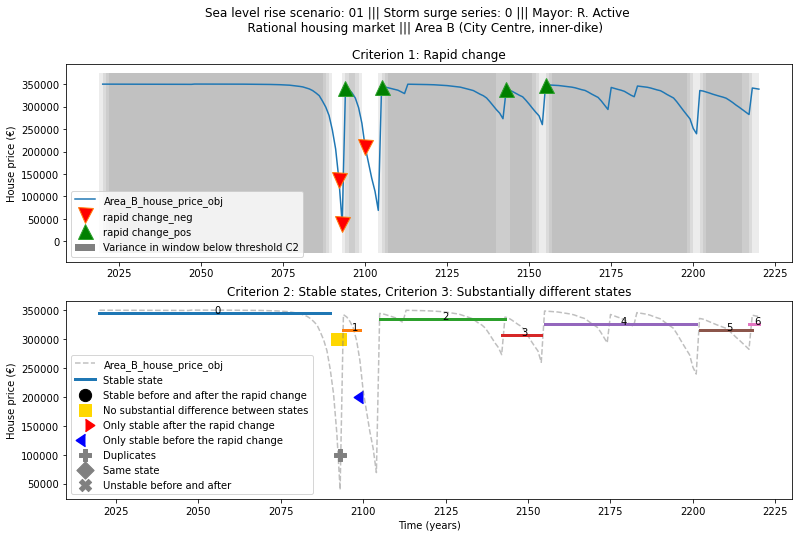

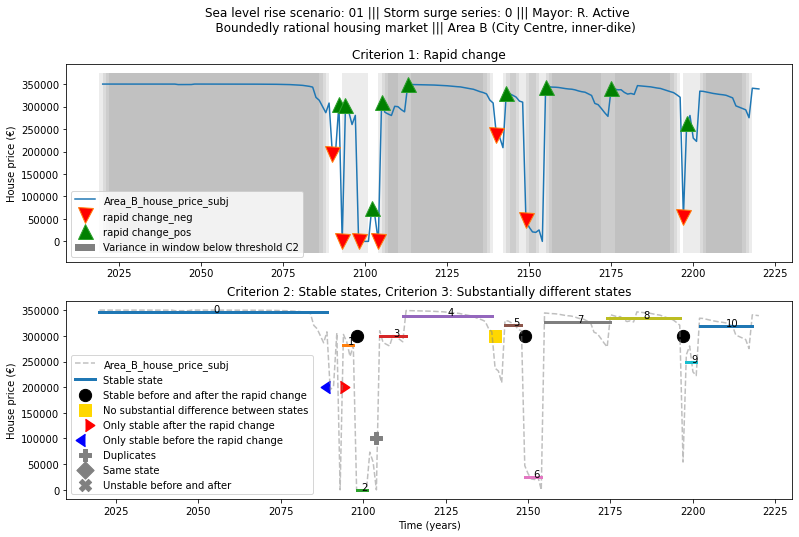

In [21]:
#Todo: show the details of the experiment in addition to the plot
exp = experiments[0]

for M in exp.allMetrics:
    fig, ax = M.plot_SETPs(figsize=(13,8))
    fig, file_string = add_suptitle(fig,exp,M)
    filename = file_string.replace(" ", "")
    #fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)
    
    del fig, ax

(<Figure size 936x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C10521D60>,
       dtype=object))

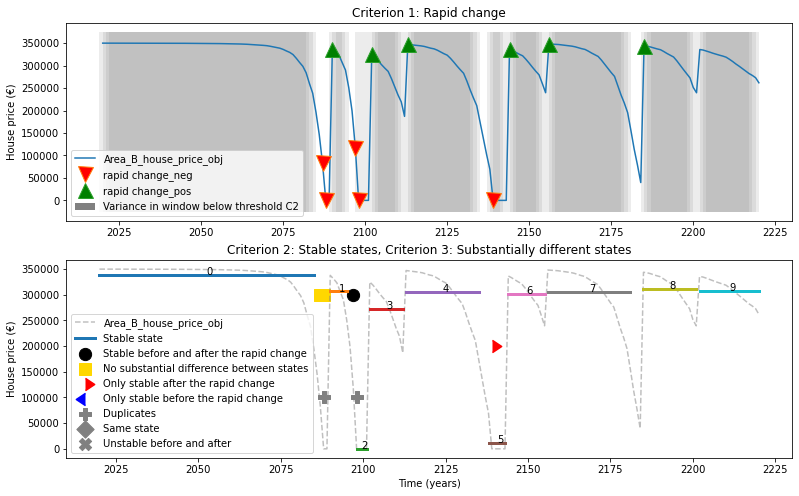

In [41]:
M = exp.allMetrics[2]
M.plot_SETPs(figsize=(13,8))

In [42]:
M.__dict__

{'raw': 2020    350000.000000
 2021    349994.089711
 2022    349987.246218
 2023    349979.469521
 2024    349971.070689
             ...      
 2296              NaN
 2297              NaN
 2298              NaN
 2299              NaN
 2300              NaN
 Name: Area_B_house_price_obj, Length: 281, dtype: float64,
 'name': 'Area_B_house_price_obj',
 '_window': 4,
 'statistics':       Area_B_house_price_obj  First order derivative (dM/dt)  \
 2020           350000.000000                             NaN   
 2021           349994.089711                       -5.910289   
 2022           349987.246218                       -6.843493   
 2023           349979.469521                       -7.776697   
 2024           349971.070689                       -8.398832   
 ...                      ...                             ...   
 2296                     NaN                             NaN   
 2297                     NaN                             NaN   
 2298                     NaN  

In [43]:
M.candidates.loc[2080:2093]

,rapid change_neg,rapid change_pos,rapid change,stable
2080,NaN,NaN,NaN,2.0
2081,NaN,NaN,NaN,2.0
2082,NaN,NaN,NaN,2.0
2083,NaN,NaN,NaN,2.0
2084,NaN,NaN,NaN,2.0
2085,NaN,NaN,NaN,2.0
2086,NaN,NaN,NaN,NaN
2087,82522.698355,NaN,-1.0,NaN
2088,0.000000,NaN,-1.0,NaN
2089,NaN,NaN,NaN,NaN


In [44]:
M.stable_states

[(2020, 2085),
 (2090, 2095),
 (2098, 2101),
 (2102, 2112),
 (2113, 2135),
 (2138, 2143),
 (2144, 2155),
 (2156, 2181),
 (2185, 2201),
 (2202, 2220)]

In [45]:
M.allSETPs_cands[0:5]

[2087__-1__us__dup_first -dups with: (2088),
 2088__-1__us__dup_,
 2090__1__oa__None_,
 2097__-1__real__dup_first -dups with: (2098),
 2098__-1__real__dup_]

In [46]:
M.statistics.loc[2075:2100]

,Area_B_house_price_obj,First order derivative (dM/dt),Second order derivative (d2M/dt2),Window mean,Window variance
2075,336059.493698,-2668.962269,-1146.285077,339165.661849,5.686321e+06
2076,332570.556541,-3488.937157,-819.974888,336902.409841,1.134128e+07
2077,329419.128016,-3151.428525,337.508632,334194.408555,1.649211e+07
2078,324595.087589,-4824.040427,-1672.611902,330661.066461,2.370923e+07
2079,316297.041262,-8298.046327,-3474.005899,325720.453352,5.022375e+07
2080,307057.081445,-9239.959817,-941.913491,319342.084578,9.644481e+07
2081,298422.770758,-8634.310687,605.649130,311592.995263,1.284039e+08
2082,284131.690973,-14291.079785,-5656.769098,301477.146110,1.869863e+08
2083,260317.579616,-23814.111357,-9523.031573,287482.280698,4.173382e+08
2084,238581.090519,-21736.489097,2077.622260,270363.282967,6.959759e+08


In [25]:
random.shuffle(experiments)
experiments[0:10]

[Rotty_Scenario_03__five_hundred_312_R. Active_(11, 16) 2021/02/19, 11:18:37,
 Rotty_Scenario_01__five_hundred_451_H. Economicus_(9, 13) 2021/02/19, 11:16:46,
 Rotty_Scenario_02__five_hundred_4_Lawkeeper_(4, 6) 2021/02/19, 11:17:42,
 Rotty_Scenario_05__five_hundred_429_Lawkeeper_(14, 20) 2021/02/19, 11:21:11,
 Rotty_Scenario_02__five_hundred_312_Lawkeeper_(14, 20) 2021/02/19, 11:17:36,
 Rotty_Scenario_04__five_hundred_2_Lawkeeper_(7, 10) 2021/02/19, 11:19:27,
 Rotty_Scenario_02__five_hundred_312_H. Economicus_(7, 10) 2021/02/19, 11:17:32,
 Rotty_Scenario_02__five_hundred_272_Lawkeeper_(14, 20) 2021/02/19, 11:17:23,
 Rotty_Scenario_07__five_hundred_429_R. Active_(9, 13) 2021/02/19, 11:22:14,
 Rotty_Scenario_05__five_hundred_312_H. Economicus_(7, 10) 2021/02/19, 11:20:52]

In [24]:
for exp in tqdm(experiments[0:10]):
    for M in exp.allMetrics:
        fig, ax = M.plot_SETPs(figsize=(13,8))
        fig, file_string = add_suptitle(fig,exp,M)
        filename = file_string.replace(" ", "")
        fig.savefig(Path(target, (filename + ".png")),bbox_inches='tight',dpi=150)
        plt.close(fig)
        del fig, ax